In [1]:
import sys
sys.path.append('../experiments')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import utils
import joblib
import pandas as pd
# from run_experiment import run_experiment
# import pmsurv_exponential 
import pmsurv_weibull
# import pmsurv_weibull_nn
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
# from pmsurv.models.exponential_model import ExponentialModel
from pmsurv.models.weibull_linear import WeibullModelLinear
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pmsurv

In [4]:
SEED = 42

In [5]:
dataset, config = utils.load_data('../experiments/data/veteran')
train_kwargs = {'jobs': 5, 'n_iter': 10}


In [6]:
dataset['celltype_1:trt'] = dataset['celltype_1'] * dataset['trt_2']
dataset['celltype_2:trt'] = dataset['celltype_2'] * dataset['trt_2']
dataset['celltype_3:trt'] = dataset['celltype_3'] * dataset['trt_2']
dataset['celltype_4:trt'] = dataset['celltype_4'] * dataset['trt_2']

config['features'] = ['age', 'trt_2', 'celltype_2', 'celltype_3', 'celltype_4', 'celltype_2:trt', 'celltype_3:trt', 'celltype_4:trt']
config['preprocessing']['standardize'] = True
config['preprocessing']['continuous_features'] = ['age']
continuous_features = config['preprocessing']['continuous_features']

In [7]:
dataset[config['features']]

,age,trt_2,celltype_2,celltype_3,celltype_4,celltype_2:trt,celltype_3:trt,celltype_4:trt
0,69,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,64,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,63,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,65,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
132,65,1.0,0.0,0.0,1.0,0.0,0.0,1.0
133,64,1.0,0.0,0.0,1.0,0.0,0.0,1.0
134,67,1.0,0.0,0.0,1.0,0.0,0.0,1.0
135,65,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [8]:
X_predict_original = pd.DataFrame({
    'age': [50, 50, 65, 65],
    'trt_2': [0, 0, 1, 0],
    'celltype_2': [0, 0, 1, 1], 
    'celltype_3': [1, 1, 0, 0], 
    'celltype_4': [0, 0, 0, 0], 
    'celltype_2:trt': [0, 0, 1, 0], 
    'celltype_3:trt': [1, 0, 0, 0],  
    'celltype_4:trt': [0, 0, 0, 0],
})
X_predict_original

,age,trt_2,celltype_2,celltype_3,celltype_4,celltype_2:trt,celltype_3:trt,celltype_4:trt
0,50,0,0,1,0,0,1,0
1,50,0,0,1,0,0,0,0
2,65,1,1,0,0,1,0,0
3,65,0,1,0,0,0,0,0


In [9]:
def train_model_generic(dataset, config, train_kwargs, preprocess_data_fun, train_fun):
    dataset = dataset.dropna(subset=config['features'])
    X, y = preprocess_data_fun(dataset, config)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=config['split']['test_size'],
                                                        shuffle=config['split']['shuffle'])

    if config['preprocessing']['standardize']:
        X_train, X_test, scaler = utils.standardize(X_train, X_test, config)
    else:
        scaler = None

    pipeline, parameters, fit_params = train_fun(X_train, y_train, config, train_kwargs)
    n_cv = 5
    n_points = int(train_kwargs['jobs'] / n_cv)
    opt = BayesSearchCV(pipeline, parameters,
                        fit_params=fit_params,
                        n_jobs=train_kwargs['jobs'],
                        n_points=n_points if n_points > 1 else 1,
                        n_iter=train_kwargs['n_iter'],
                        cv=n_cv,
                        error_score='raise')
    opt.fit(X_train, y_train)
    metrics = opt.best_estimator_.score(X_test, y_test)
    print("Test metrics: " + str(metrics))

    return metrics, opt.best_estimator_, opt.best_params_, scaler, (X_train, X_test, y_train, y_test)

# Train

In [10]:
import pmsurv_weibull

In [11]:
metrics, model_wb, best_params_wb, scaler_wb, _ = train_model_generic(dataset, config, train_kwargs, pmsurv_weibull.preprocess_data, pmsurv_weibull.train_model)

/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/site-packages/pymc/sampling_jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")
/usr/local/lib/python3.10/site-packages/pymc/sampling_jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")
/usr/local/lib/python3.10/site-packages/pymc/sampling_jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")
/usr/local/lib/python3.10/site-packages/pymc/sampling_jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")
/usr/local/lib/python3.10/site-packages/pymc/sampling_j

Compiling...
Compilation time =  0:00:25.948579
Sampling...
Compiling...
Compilation time =  0:00:25.848215
Sampling...
Compiling...
Compilation time =  0:00:26.054330
Sampling...
Compiling...
Compilation time =  0:00:25.719519
Sampling...
Compiling...
Compilation time =  0:00:25.812520
Sampling...


Running chain 1: 100%|██████████| 3000/3000 [00:16<00:00, 176.97it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:17<00:00, 172.74it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:17<00:00, 168.16it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior pr

Sampling time =  0:00:18.542027
Transforming variables...
Transformation time =  0:00:03.812719
Computing Log Likelihood...
Log Likelihood time =  0:00:02.182131
fitted
Compiling...
Compilation time =  0:00:04.482166
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:19.100002
Transforming variables...
Transformation time =  0:00:03.549930
Computing Log Likelihood...
Log Likelihood time =  0:00:02.063170
fitted
Compiling...
Compilation time =  0:00:04.661262
Sampling...
Sampling time =  0:00:18.244826
Transforming variables...
Transformation time =  0:00:04.221200
Computing Log Likelihood...
Log Likelihood time =  0:00:02.034209
fitted
Compiling...
Compilation time =  0:00:04.933760
Sampling...
Sampling time =  0:00:18.518279
Transforming variables...
Transformation time =  0:00:04.017632
Computing Log Likelihood...
Log Likelihood time =  0:00:01.961603
fitted
Compiling...
Compilation time =  0:00:04.949948
Sampling...
Sampling time =  0:00:18.880494
Transforming variables...
Transformation time =  0:00:03.908024
Computing Log Likelihood...
Log Likelihood time =  0:00:02.000128
fitted
Compiling...
Compilation time =  0:00:05.162281
Sampling...


Running chain 0:  30%|███       | 900/3000 [00:12<00:01, 1497.44it/s]]

Running chain 0:  10%|█         | 300/3000 [00:12<00:02, 1214.24it/s]

Running chain 0:  90%|█████████ | 2700/3000 [00:13<00:00, 1717.62it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:13<00:00, 224.51it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:14<00:00, 212.46it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:14<00:00, 207.25it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterio

Sampling time =  0:00:14.208204
Transforming variables...
Transformation time =  0:00:01.121550
Computing Log Likelihood...
Log Likelihood time =  0:00:01.721503
fitted
Compiling...
Compilation time =  0:00:02.663347
Sampling...
Sampling time =  0:00:15.379910
Transforming variables...
Transformation time =  0:00:00.686603
Computing Log Likelihood...
Log Likelihood time =  0:00:00.741846
fitted
Compiling...
Compilation time =  0:00:02.800081
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:15.057639
Transforming variables...
Transformation time =  0:00:00.614541
Computing Log Likelihood...
Log Likelihood time =  0:00:01.501965
fitted
Compiling...
Compilation time =  0:00:02.855526
Sampling...
Sampling time =  0:00:14.340937
Transforming variables...
Transformation time =  0:00:01.118001
Computing Log Likelihood...
Log Likelihood time =  0:00:01.522660
fitted
Compiling...
Compilation time =  0:00:02.913403
Sampling...
Sampling time =  0:00:15.031050
Transforming variables...
Transformation time =  0:00:00.521219
Computing Log Likelihood...
Log Likelihood time =  0:00:01.506388
fitted
Compiling...
Compilation time =  0:00:03.097278
Sampling...


Running chain 1: 100%|██████████| 3000/3000 [00:08<00:00, 357.43it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:08<00:00, 345.41it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:09<00:00, 330.62it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other param

Sampling time =  0:00:09.581867
Transforming variables...
Transformation time =  0:00:00.204113
Computing Log Likelihood...
Log Likelihood time =  0:00:00.443400
fitted
Compiling...
Compilation time =  0:00:03.258135
Sampling...
Sampling time =  0:00:08.906457
Transforming variables...
Transformation time =  0:00:00.221993
Computing Log Likelihood...
Log Likelihood time =  0:00:00.655150
fitted
Compiling...
Compilation time =  0:00:03.223157
Sampling...
Sampling time =  0:00:09.515497
Transforming variables...
Transformation time =  0:00:00.292246
Computing Log Likelihood...
Log Likelihood time =  0:00:00.469966
fitted
Compiling...
Compilation time =  0:00:03.185437
Sampling...
Sampling time =  0:00:08.753997
Transforming variables...
Transformation time =  0:00:00.257647
Computing Log Likelihood...
Log Likelihood time =  0:00:01.219351
fitted
Compiling...
Compilation time =  0:00:03.176335
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:09.049554
Transforming variables...
Transformation time =  0:00:00.220131
Computing Log Likelihood...
Log Likelihood time =  0:00:01.144597
fitted
Compiling...
Compilation time =  0:00:03.274883
Sampling...


Running chain 0:  20%|██        | 600/3000 [00:09<00:00, 5013.89it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:09<00:00, 300.57it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:10<00:00, 288.37it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:11<00:00, 272.05it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/w

Sampling time =  0:00:10.980277
Transforming variables...
Transformation time =  0:00:00.270926
Computing Log Likelihood...
Log Likelihood time =  0:00:00.723972
fitted
Compiling...
Compilation time =  0:00:03.488550
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:10.466599
Transforming variables...
Transformation time =  0:00:00.398979
Computing Log Likelihood...
Log Likelihood time =  0:00:00.494910
fitted
Compiling...
Compilation time =  0:00:03.646962
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:10.359532
Transforming variables...
Transformation time =  0:00:00.269364
Computing Log Likelihood...
Log Likelihood time =  0:00:00.770702
fitted
Compiling...
Compilation time =  0:00:04.057647
Sampling...
Sampling time =  0:00:10.470162
Transforming variables...
Transformation time =  0:00:00.290381
Computing Log Likelihood...
Log Likelihood time =  0:00:00.863772
fitted
Compiling...
Compilation time =  0:00:04.107798
Sampling...
Sampling time =  0:00:11.403344
Transforming variables...
Transformation time =  0:00:00.397085
Computing Log Likelihood...
Log Likelihood time =  0:00:00.469739
fitted
Compiling...
Compilation time =  0:00:04.140584
Sampling...


Running chain 0:  10%|█         | 300/3000 [00:11<00:00, 2837.09it/s]]

Running chain 1: 100%|██████████| 3000/3000 [00:11<00:00, 259.71it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:12<00:00, 244.45it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:11<00:00, 250.91it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The

Sampling time =  0:00:11.960425
Transforming variables...
Transformation time =  0:00:00.622451
Computing Log Likelihood...
Log Likelihood time =  0:00:01.476866
fitted
Compiling...
Compilation time =  0:00:02.579020
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:12.512601
Transforming variables...
Transformation time =  0:00:00.340664
Computing Log Likelihood...
Log Likelihood time =  0:00:00.740623
fitted
Compiling...
Compilation time =  0:00:02.950988
Sampling...
Sampling time =  0:00:12.802828
Transforming variables...
Transformation time =  0:00:00.574479
Computing Log Likelihood...
Log Likelihood time =  0:00:00.678604
fitted
Compiling...
Compilation time =  0:00:03.004595
Sampling...
Sampling time =  0:00:12.508600
Transforming variables...
Transformation time =  0:00:00.393322
Computing Log Likelihood...
Log Likelihood time =  0:00:01.284134
fitted
Compiling...
Compilation time =  0:00:03.172975
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:12.178689
Transforming variables...
Transformation time =  0:00:00.381965
Computing Log Likelihood...
Log Likelihood time =  0:00:01.222251
fitted
Compiling...
Compilation time =  0:00:03.336467
Sampling...


Running chain 1: 100%|██████████| 3000/3000 [00:12<00:00, 248.20it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:12<00:00, 235.49it/s] 

Running chain 1:  10%|█         | 300/3000 [00:13<00:01, 2513.33it/s]/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Running chain 0:  40%|████      | 1200/3000 [00:13<00:00, 6094.14it/s]
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Running chain 1:  25%|██▌       | 750/3000 [00:13<00:00, 3422.02it/s

Sampling time =  0:00:12.641041
Transforming variables...
Transformation time =  0:00:00.301714
Computing Log Likelihood...
Log Likelihood time =  0:00:00.793079
fitted
Compiling...
Compilation time =  0:00:02.506196
Sampling...
Sampling time =  0:00:12.875916
Transforming variables...
Transformation time =  0:00:00.634480
Computing Log Likelihood...
Log Likelihood time =  0:00:00.786448
fitted
Compiling...
Compilation time =  0:00:02.555180
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:13.472594
Transforming variables...
Transformation time =  0:00:00.495460
Computing Log Likelihood...
Log Likelihood time =  0:00:00.795990
fitted
Compiling...
Compilation time =  0:00:02.559848
Sampling...
Sampling time =  0:00:13.997050
Transforming variables...
Transformation time =  0:00:00.291497
Computing Log Likelihood...
Log Likelihood time =  0:00:00.839312
fitted
Compiling...
Compilation time =  0:00:02.729608
Sampling...
Sampling time =  0:00:12.307511
Transforming variables...
Transformation time =  0:00:00.470136
Computing Log Likelihood...
Log Likelihood time =  0:00:00.867633
fitted
Compiling...
Compilation time =  0:00:02.724169
Sampling...


Running chain 1:  95%|█████████▌| 2850/3000 [00:11<00:00, 4459.59it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:11<00:00, 265.37it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:11<00:00, 257.22it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:12<00:00, 249.83it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The

Sampling time =  0:00:11.865603
Transforming variables...
Transformation time =  0:00:00.368085
Computing Log Likelihood...
Log Likelihood time =  0:00:00.604941
fitted
Compiling...
Compilation time =  0:00:02.702482
Sampling...
Sampling time =  0:00:12.158173
Transforming variables...
Transformation time =  0:00:00.297289
Computing Log Likelihood...
Log Likelihood time =  0:00:00.740859
fitted
Compiling...
Compilation time =  0:00:02.903635
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:11.826659
Transforming variables...
Transformation time =  0:00:00.551860
Computing Log Likelihood...
Log Likelihood time =  0:00:00.606911
fitted
Compiling...
Compilation time =  0:00:02.883732
Sampling...
Sampling time =  0:00:11.675521
Transforming variables...
Transformation time =  0:00:00.546481
Computing Log Likelihood...
Log Likelihood time =  0:00:00.732457
fitted
Compiling...
Compilation time =  0:00:02.967902
Sampling...
Sampling time =  0:00:12.437628
Transforming variables...
Transformation time =  0:00:00.485622
Computing Log Likelihood...
Log Likelihood time =  0:00:00.485977
fitted
Compiling...
Compilation time =  0:00:03.016413
Sampling...


Running chain 0:  20%|██        | 600/3000 [00:12<00:01, 2207.52it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:12<00:00, 231.16it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:13<00:00, 218.55it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The 

Sampling time =  0:00:12.885776
Transforming variables...
Transformation time =  0:00:00.548073
Computing Log Likelihood...
Log Likelihood time =  0:00:01.056473
fitted
Compiling...
Compilation time =  0:00:02.658118
Sampling...
Sampling time =  0:00:13.725577
Transforming variables...
Transformation time =  0:00:00.448509
Computing Log Likelihood...
Log Likelihood time =  0:00:00.927219
fitted
Compiling...
Compilation time =  0:00:02.781156
Sampling...
Sampling time =  0:00:13.568585
Transforming variables...
Transformation time =  0:00:00.301441
Computing Log Likelihood...
Log Likelihood time =  0:00:00.684853
fitted
Compiling...
Compilation time =  0:00:02.815589
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:13.517099
Transforming variables...
Transformation time =  0:00:00.591130
Computing Log Likelihood...
Log Likelihood time =  0:00:00.798122
fitted
Compiling...
Compilation time =  0:00:02.811274
Sampling...
Sampling time =  0:00:14.196368
Transforming variables...
Transformation time =  0:00:00.596138
Computing Log Likelihood...
Log Likelihood time =  0:00:01.031963
fitted
Compiling...
Compilation time =  0:00:02.986351
Sampling...


Running chain 0:  35%|███▌      | 1050/3000 [00:11<00:00, 4547.29it/s][A

Running chain 1:  20%|██        | 600/3000 [00:11<00:01, 1706.75it/s]

Running chain 0:  25%|██▌       | 750/3000 [00:12<00:01, 2205.65it/s]]

Running chain 0:  50%|█████     | 1500/3000 [00:11<00:00, 2971.93it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:12<00:00, 240.44it/s] 


Running chain 1:   5%|▌         | 150/3000 [00:12<00:02, 1387.67it/s]A

Running chain 1: 100%|██████████| 3000/3000 [00:12<00:00, 244.76it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:13<00:00, 221.30it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other par

Sampling time =  0:00:13.389506
Transforming variables...
Transformation time =  0:00:00.422111
Computing Log Likelihood...
Log Likelihood time =  0:00:01.255738
fitted
Compiling...
Compilation time =  0:00:04.537716
Sampling...
Sampling time =  0:00:14.026050
Transforming variables...
Transformation time =  0:00:00.447949
Computing Log Likelihood...
Log Likelihood time =  0:00:00.637101
fitted
Compiling...
Compilation time =  0:00:04.468570
Sampling...
Sampling time =  0:00:12.930675
Transforming variables...
Transformation time =  0:00:00.480784
Computing Log Likelihood...
Log Likelihood time =  0:00:01.541945
fitted
Compiling...
Compilation time =  0:00:04.632158
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:13.214085
Transforming variables...
Transformation time =  0:00:00.520360
Computing Log Likelihood...
Log Likelihood time =  0:00:00.712441
fitted
Compiling...
Compilation time =  0:00:04.704006
Sampling...
Sampling time =  0:00:13.102238
Transforming variables...
Transformation time =  0:00:00.457801
Computing Log Likelihood...
Log Likelihood time =  0:00:00.741562
fitted
Compiling...
Compilation time =  0:00:04.826119
Sampling...


Running chain 0:  20%|██        | 600/3000 [00:12<00:01, 2066.00it/s]][A

Running chain 1:  30%|███       | 900/3000 [00:12<00:01, 1883.52it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:13<00:00, 228.07it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:13<00:00, 217.20it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: Th

Compiling...


Compilation time =  0:00:01.901759
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:06.942469
Transforming variables...
Transformation time =  0:00:00.480616
Computing Log Likelihood...


/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []


Log Likelihood time =  0:00:01.032688
fitted
Test metrics: 0.5340599455040872
Sampling time =  0:00:13.692478
Transforming variables...
Transformation time =  0:00:00.475529
Computing Log Likelihood...
Log Likelihood time =  0:00:00.855724
fitted
Sampling time =  0:00:13.688335
Transforming variables...
Transformation time =  0:00:00.772091
Computing Log Likelihood...
Log Likelihood time =  0:00:00.810074
fitted
Sampling time =  0:00:13.860730
Transforming variables...
Transformation time =  0:00:00.499951
Computing Log Likelihood...
Log Likelihood time =  0:00:00.750776
fitted
Sampling time =  0:00:14.417912
Transforming variables...
Transformation time =  0:00:00.632403
Computing Log Likelihood...
Log Likelihood time =  0:00:00.723595
fitted
Sampling time =  0:00:14.346353
Transforming variables...
Transformation time =  0:00:00.728275
Computing Log Likelihood...
Log Likelihood time =  0:00:00.954166
fitted


In [12]:
X_predict = X_predict_original.copy()
X_predict[continuous_features] = scaler_wb.transform(X_predict[continuous_features])
surv_wb, surv_wb_lower, surv_wb_upper = model_wb.predict(X_predict)
t_plot_wb = pmsurv.utils.get_time_axis(0, model_wb['model'].max_time, 10) / 30.25

/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []


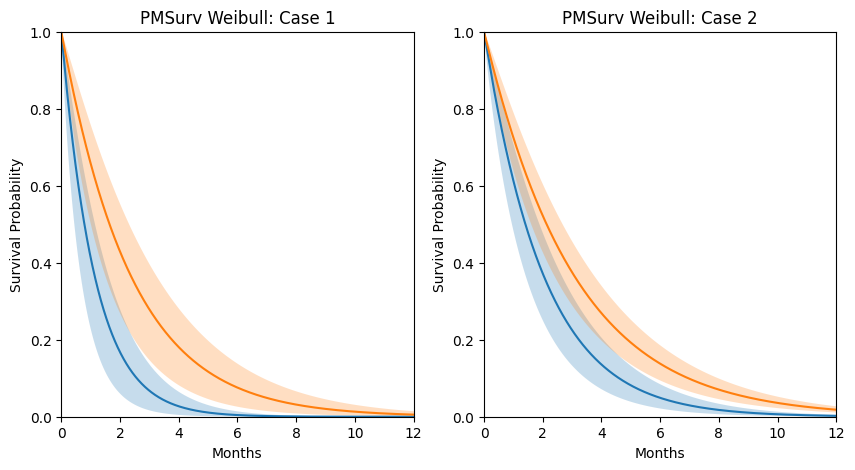

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("PMSurv Weibull: Case 1");
plt.plot(t_plot_wb, surv_wb[0]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[0], y2=surv_wb_upper[0], alpha=0.25);
plt.plot(t_plot_wb, surv_wb[1]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[1], y2=surv_wb_upper[1], alpha=0.25);
plt.ylim(0, 1);
plt.xlim(0, 12);
plt.ylabel("Survival Probability");
plt.xlabel("Months");

plt.subplot(1, 2, 2)
plt.title("PMSurv Weibull: Case 2");
plt.plot(t_plot_wb, surv_wb[2]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[2], y2=surv_wb_upper[2], alpha=0.25);
plt.plot(t_plot_wb, surv_wb[3]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[3], y2=surv_wb_upper[3], alpha=0.25);
plt.ylim(0, 1);
plt.xlim(0, 12);
plt.ylabel("Survival Probability");
plt.xlabel("Months");

In [17]:
import numpy as np
import seaborn as sns

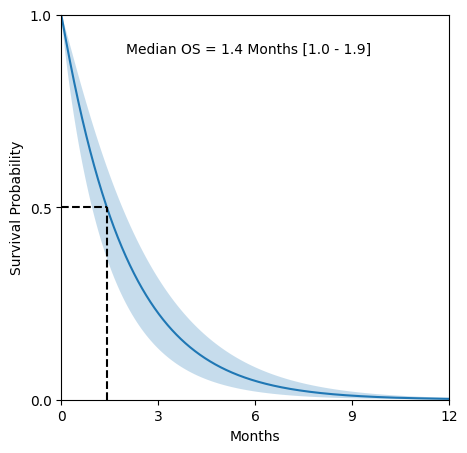

In [18]:
idx = 2
surv = surv_wb[idx]
surv_lower = surv_wb_lower[idx]
surv_upper = surv_wb_upper[idx]
              
median_os = t_plot_wb[np.argmax(surv < 0.5)]
median_os_lower = t_plot_wb[np.argmax(surv_lower < 0.5)]
median_os_upper = t_plot_wb[np.argmax(surv_upper < 0.5)]

plt.figure(figsize=(5, 5))
ax = sns.lineplot(x=t_plot_wb, y=surv)
plt.fill_between(t_plot_wb, y1=surv_lower, y2=surv_upper, alpha=0.25);
plt.hlines(y=0.5, xmin=0, xmax=median_os, colors='black', linestyles='dashed')
plt.vlines(x=median_os, ymin=0, ymax=0.5, colors='black', linestyles='dashed')
plt.text(x=2, y=0.9, s=f"Median OS = {median_os:0.1f} Months [{median_os_lower:0.1f} - {median_os_upper:0.1f}]")
plt.ylim(0, 1);
plt.xlim(0, 12);
ax.set(xticks=[0, 3, 6, 9, 12], yticks=[0, 0.5, 1], ylabel='Survival Probability', xlabel='Months');


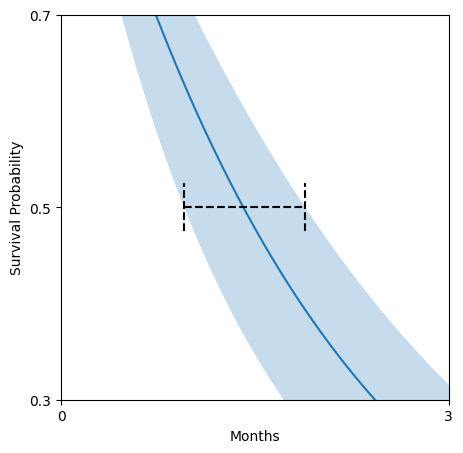

In [19]:
plt.figure(figsize=(5, 5))
ax = sns.lineplot(x=t_plot_wb, y=surv)
plt.fill_between(t_plot_wb, y1=surv_lower, y2=surv_upper, alpha=0.25);
plt.hlines(y=0.5, xmin=median_os_lower, xmax=median_os_upper, colors='black', linestyles='dashed')
plt.vlines(x=median_os_lower, ymin=0.475, ymax=0.525, colors='black', linestyles='dashed')
plt.vlines(x=median_os_upper, ymin=0.475, ymax=0.525, colors='black', linestyles='dashed')

# plt.text(x=3, y=0.75, s=f"Median OS = {median_os:0.1f} Months [{median_os_lower:0.1f} - {median_os_upper:0.1f}]")
plt.ylim(0.3, 0.7);
plt.xlim(1, 3);
ax.set(xticks=[0, 3], yticks=[0.3, 0.5, 0.7], ylabel='Survival Probability', xlabel='Months');

In [20]:
import arviz as az

In [21]:
import seaborn as sns

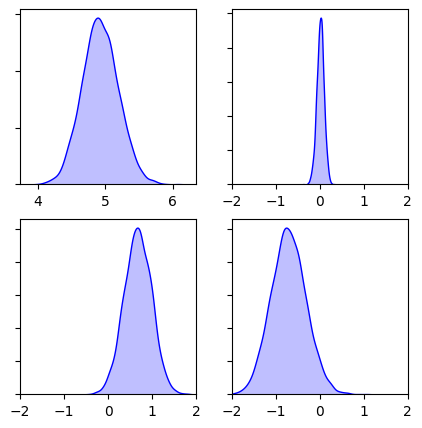

In [22]:
xlimits = [-2, 2]
plt.figure(figsize=(5, 5))
plt.subplot(2, 2, 1)
posterior = model_wb['model'].trace.posterior['lambda_intercept'].values.flatten()
ax = sns.kdeplot(posterior, color='blue', fill=True);
# plt.xlim(xlimits)
# ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], ylabel='');
ax.set(yticklabels=[], ylabel='');


plt.subplot(2, 2, 2)
posterior = model_wb['model'].trace.posterior['k_intercept'].values.flatten()
ax = sns.kdeplot(posterior, color='blue', fill=True);
# ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], ylabel='');
ax.set(yticklabels=[], ylabel='');

plt.xlim(xlimits)

plt.subplot(2, 2, 3)
posterior = model_wb['model'].trace.posterior['lambda_column_0'].values.flatten()
ax = sns.kdeplot(posterior, color='blue', fill=True);
# ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], ylabel='');
ax.set(yticklabels=[], ylabel='');
plt.xlim(xlimits)

plt.subplot(2, 2, 4)
posterior = model_wb['model'].trace.posterior['lambda_column_2'].values.flatten()
ax = sns.kdeplot(posterior, color='blue', fill=True);
# ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], ylabel='');
ax.set(yticklabels=[], ylabel='');
plt.xlim(xlimits);


In [23]:
model_wb['model'].trace.posterior.keys()


KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 2000, lambda_det_dim_0: 109,
                       k_det_dim_0: 109)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 ... 1994 1995 1996 1997 1998 1999
  * lambda_det_dim_0  (lambda_det_dim_0) int64 0 1 2 3 4 ... 104 105 106 107 108
  * k_det_dim_0       (k_det_dim_0) int64 0 1 2 3 4 5 ... 104 105 106 107 108
Data variables:
    lambda_intercept  (chain, draw) float64 4.946 5.119 5.096 ... 4.737 5.111
    k_intercept       (chain, draw) float64 -0.09281 -0.007862 ... 0.03876
    lambda_column_0   (chain, draw) float64 0.3152 0.4673 ... 0.7715 0.5396
    lambda_column_1   (chain, draw) float64 -0.5648 -0.9986 ... -0.2006 -0.393
    lambda_column_2   (chain, draw) float64 -0.6185 -1.065 ... -1.059 -0.7378
    lambda_column_3   (chain, draw) float64 0.06965 0.2926 ... 0.5256 0.2336
    lambda_column_4   (chain, draw) float64 -0.2621 -0.904 ... -1.083 -1.097
    lambda_colum

In [24]:
cols = ['lambda_intercept', 'trt_2', 'celltype_2', 'celltype_3', 'celltype_4', 'celltype_2:trt', 'celltype_3:trt', 'celltype_4:trt']
cols_post = ['lambda_intercept',  'lambda_column_0', 'lambda_column_1', 'lambda_column_2', 'lambda_column_3', 'lambda_column_4', 'lambda_column_5', 'lambda_column_6']


In [25]:
df_posteriors = pd.DataFrame({
    'column': np.repeat(cols, 4000),
    'samples': np.concatenate([model_wb['model'].trace.posterior[c].values.flatten() for c in cols_post])
})

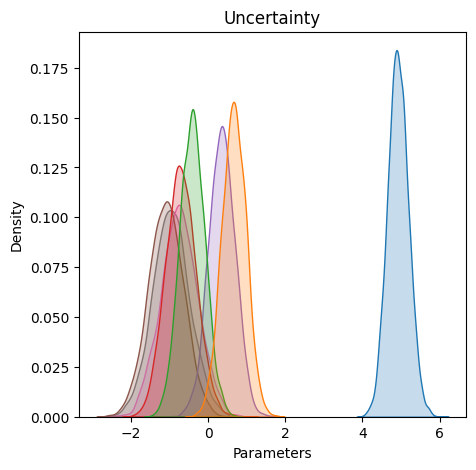

In [52]:
plt.figure(figsize=(5, 5))
plt.title("Uncertainty")
ax = sns.kdeplot(data = df_posteriors, x = 'samples', hue='column', fill=True, legend=None);
ax.set(xlabel='Parameters');

In [27]:
import pymc as pm

In [28]:
with pm.Model() as model:
    lambda_intercept = pm.Normal("λ_intercept", mu=0, sigma=1)
    k_intercept = pm.Normal("κ_intercept", mu=0, sigma=1)
    
    lambda_1 = pm.Normal("λ_age", mu=0, sigma=1)
    lambda_2 = pm.Normal("λ_trt", mu=0, sigma=1)
    lambda_3 = pm.Normal("λ_celltype", mu=0, sigma=1)
    
    lambda_det = pm.Deterministic('λ', pm.math.exp(lambda_intercept + lambda_1 + lambda_2 + lambda_3))
    k_det = pm.Deterministic('κ', pm.math.exp(k_intercept))
    
    y = pm.Weibull('y', alpha=k_det, beta=lambda_det)
    

array(['trt_2', 'celltype_2', 'celltype_3', 'celltype_4',
       'celltype_2:trt', 'celltype_3:trt', 'celltype_4:trt'], dtype=object)

In [39]:
cols = ['lambda_intercept', 'trt_2', 'celltype_2', 'celltype_3', 'celltype_4', 'celltype_2:trt', 'celltype_3:trt', 'celltype_4:trt']
cols_post = ['lambda_intercept',  'lambda_column_0', 'lambda_column_1', 'lambda_column_2', 'lambda_column_3', 'lambda_column_4', 'lambda_column_5', 'lambda_column_6']

df_posterior = pd.DataFrame({
    'column': np.repeat(cols, 4000),
    'grp': np.repeat('posterior', len(cols)*4000),
    'samples': np.concatenate([model_wb['model'].trace.posterior[c].values.flatten() for c in cols_post])
})

df_prior = pd.DataFrame({
    'column': np.repeat(cols, 4000),
    'grp': np.repeat('prior', len(cols)*4000),
    'samples': np.concatenate([model_wb['model'].trace.prior[c].values.flatten() for c in cols_post])
})

AttributeError: 'InferenceData' object has no attribute 'prior'

In [49]:
model_wb['model'].trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

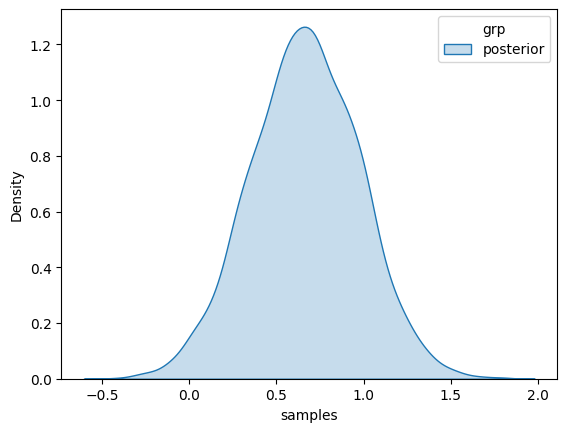

In [38]:
sns.kdeplot(data = df_bayes[df_bayes['column'] == 'trt_2'], 
            x = 'samples', hue='grp', fill=True);

